<a href="https://colab.research.google.com/github/sokrypton/ColabBio/blob/main/categorical_jacobian/evo_trna_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip -q install evo-model

In [2]:
import os
DEVICE = 'cuda:0'
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
from tqdm.notebook import tqdm
import numpy as np

In [ ]:
from evo import Evo
import torch
import numpy as np

evo_model = Evo('evo-1-8k-base')
model, tokenizer = evo_model.model, evo_model.tokenizer
DEVICE = 'cuda:0'
model.to(DEVICE)
model.eval()
print("loaded")

In [ ]:
def reverse_complement(dna_sequence):
  complement_dict = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
  # Reverse the DNA sequence
  reversed_sequence = dna_sequence[::-1]
  # Replace each nucleotide with its complement
  reverse_complement_sequence = ''.join([complement_dict[nucleotide] for nucleotide in reversed_sequence])
  return reverse_complement_sequence

def get_categorical_jacobian(input_ids, input_ids_rev=None):
  nuc_tokens = (65,67,71,84) # (A,C,G,T)
  with torch.no_grad():
    f = lambda x:model(x)[0][...,:-1,nuc_tokens].cpu().detach().float().numpy()

    x = torch.clone(input_ids)
    ln = x.shape[1] - 1

    fx = f(x.to(DEVICE))[0]
    x = torch.tile(x,[4,1]).to(DEVICE)

    if input_ids_rev is not None:
      x_rev = torch.clone(input_ids_rev)
      fx_rev = f(x_rev.to(DEVICE))[0]
      fx += fx_rev[::-1,::-1]
      x_rev = torch.tile(x_rev,[4,1]).to(DEVICE)
    else:
      x_rev = None

    fx_h = np.zeros((ln,4,ln,4),dtype=np.float32)
    with tqdm(total=ln, bar_format=TQDM_BAR_FORMAT) as pbar:
      for n in range(ln): # for each position
        x_h = torch.clone(x)
        x_h[:,n+1] = torch.tensor(nuc_tokens)
        fx_h[n] = f(x_h)
        if x_rev is not None:
          x_rev_h = torch.clone(x_rev)
          x_rev_h[:,-(1+n)] = torch.tensor(nuc_tokens)
          fx_rev_h = f(x_rev_h)
          fx_h[n] += fx_rev_h[::-1,::-1,::-1]
        pbar.update(1)
    jac = fx_h-fx
  return jac

In [ ]:
# TRNA sequence
SEQ = "GGUGGGGUUC CCGAGCGGCC AAAGGGAGCA GACUGUAAAU CUGCCGUCAU CGACUUCGAA GGUUCGAAUC CUUCCCCCAC CACCA"
SEQ = SEQ.replace(" ","").replace("U","T")

In [ ]:
input_ids = torch.tensor(
    [tokenizer.eod_id] + tokenizer.tokenize(SEQ),
    dtype=torch.int,
).to(DEVICE).unsqueeze(0)

input_ids_rev = torch.tensor(
    [tokenizer.eod_id] + tokenizer.tokenize(reverse_complement(SEQ)),
    dtype=torch.int,
).to(DEVICE).unsqueeze(0)

In [ ]:
jac_trna_control_both = get_categorical_jacobian(input_ids, input_ids_rev)

  0%|          | 0/85 [elapsed: 00:00 remaining: ?]

In [ ]:
l2n = lambda x: np.sqrt(np.square(x).sum((1,3)))

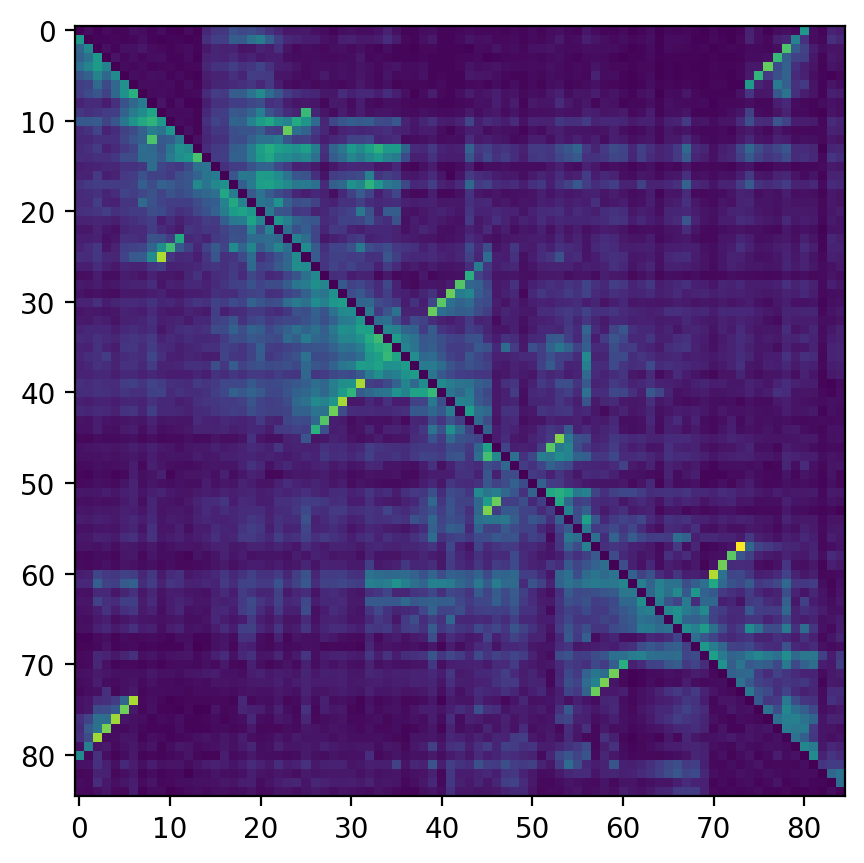

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5),dpi=200)
plt.imshow(l2n(jac_trna_control_both), cmap="gray_r")
plt.show()